<a href="https://colab.research.google.com/github/psbruno/Redes-Neurais/blob/main/RNN_Bruno_Pires.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> Rede Neural Recorrente (GRU - Gated Recurrent Unit) </h1>
<h3> Bruno Pires - RA 139892 </h3>

<p> 
Diferente de alguns outros modelos de redes neurais, que tem seu comportamento comparado com circuitos digitais combinacionais, as redes neurais recorrentes são redes com uma espécie de retroalimentação, uma espécie de memória, que lhes garantem o reconhecimento de padrões em sequências de dados, tais quais textos, séries numéricas, genomas, bolsas de valores e diversos outros.
</p>

Dois exemplos dessas redes são a GRU, Gated Recorrenct Unit, e a LSTM, Long Short-Term Memory, com possuem mecanismos similares, que são responsáveis por regular o fluxo de informações. No caso da GRU, o modelo adotado para esse caso, temos esse fluxo de informações regulados por dois portões: um de reset e outro de atualização, que decidem o que será dado na saída.
Os dados utilizados para as duas simulações serão os valores diários das ações da Petrobrás e da AMBEV, entre o início de 2017 até o fim de 2021.

Materias auxiliares consultados:





*   [Deep Learning Book](https://www.deeplearningbook.com.br/arquitetura-de-redes-neurais-gated-recurrent-unit-gru/)
*   Funções e parte do código - [Kaggle](https://www.kaggle.com/)
*   Obtenção dos [preços históricos das ações](https://www.minadedados.com.br/2020/08/obtendo-precos-historicos-de-acoes.html)



#Bibliotecas utilizadas

In [ ]:
import numpy as np 
from numpy import newaxis
import pandas as pd 
import tensorflow as tf
from tensorflow import keras
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import datetime
import pandas_datareader.data as pdr
!pip install yfinance
import yfinance as yf
yf.pdr_override()
from tensorflow.keras import layers
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Funções de plot e tratamento de dados

In [2]:
sc = MinMaxScaler(feature_range=(0,1))
def setup_data(datasetname, column, seq_len):
    data = datasetname.loc[:,column]
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    normalised_data = []
    for window in result:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    result = np.array(normalised_data)

    row = round(0.8 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    x_test = result[int(row):, :-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, train[:, -1], x_test, result[int(row):, -1]]

def plot_results(predicted_data, true_data): 
    fig = plt.figure() 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='Valor real') 
    plt.plot(predicted_data, label='Valor calculado pela predição') 
    plt.legend() 
    plt.show() 
    

#Simulação com ações da Petrobras

Note que temos o período de 5 anos dos valores de fechamento diários da bolsa da petrobrás. Desse período, 4 anos serão destinados para treino, e 1 ano para teste, conforme esquematizado no gráfico. Já para a rede, definimos a dimensionalidade do espaço, a função de ativação, assim como a de perda, entre outros.

[*********************100%***********************]  1 of 1 completed


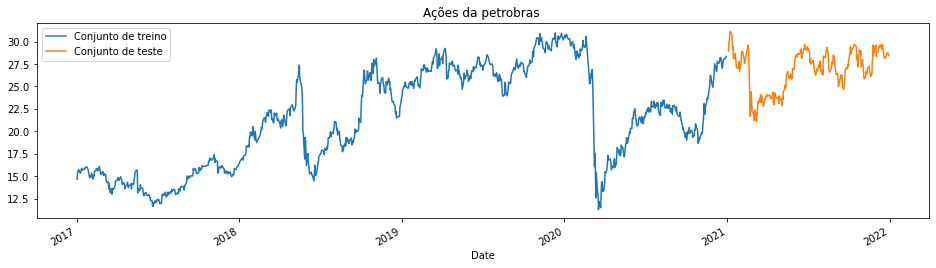

In [3]:
start = datetime.datetime(2017,1, 1)
end = datetime.datetime(2021, 12,31)
petro = pdr.get_data_yahoo('PETR4.SA',start,end)  #acoes da Petrobrás no ano de 2021

feature_train, label_train, feature_test, label_test = setup_data(petro, 'Close', 100)

petro["Close"][:'2020'].plot(figsize=(16,4),legend=True)
petro["Close"]['2021':].plot(figsize=(16,4),legend=True)
plt.legend(['Conjunto de treino','Conjunto de teste'])
plt.title('Ações da petrobras ')
plt.show()

In [12]:
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))
model.compile(loss='mean_squared_error',optimizer = 'adam')
model.fit(feature_train, label_train, batch_size=128, epochs=5, validation_data = (feature_test, label_test), verbose=0)


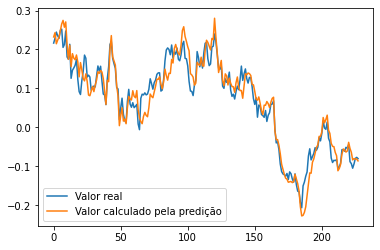

In [13]:
plot_results(
    model.predict(feature_test),
    label_test)

#Ambev

Temos a mesma ideia, porém, com alguns atributos diferentes mas que nos levam a um mesmo resultado, dado os valores preditos pelo modelo.

[*********************100%***********************]  1 of 1 completed


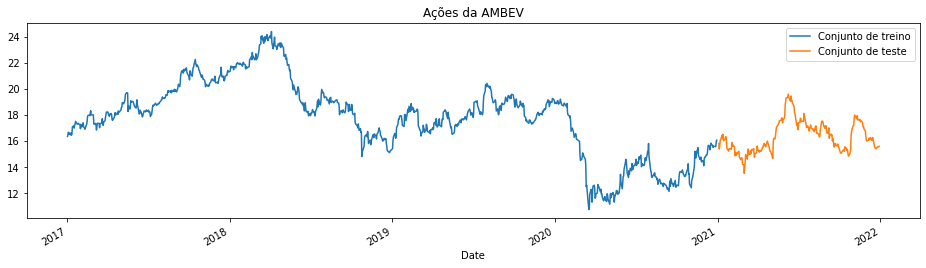

In [7]:
start = datetime.datetime(2017,1, 1)
end = datetime.datetime(2021, 12,31)
ambev = pdr.get_data_yahoo('ABEV3.SA',start,end) 

feature_train, label_train, feature_test, label_test = setup_data(ambev, 'Open', 100)

ambev["Open"][:'2020'].plot(figsize=(16,4),legend=True)
ambev["Open"]['2021':].plot(figsize=(16,4),legend=True) 
plt.legend(['Conjunto de treino','Conjunto de teste'])
plt.title('Ações da AMBEV')
plt.show()

In [8]:
model = Sequential()
model.add(GRU(15, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(GRU(40, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))
model.compile(loss='mean_squared_error',optimizer = 'adam')
model.fit(feature_train, label_train, 
          batch_size=256, epochs=15, validation_data = (feature_test, label_test), verbose=0)


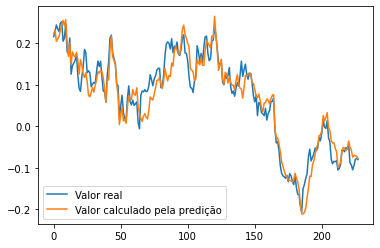

In [9]:
plot_results(
    model.predict(feature_test),
    label_test)